# Sentiment Analysis

## Import necessary libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santhosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/santhosh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load dataset

In [2]:
df = pd.read_csv('./datasets/training.1600000.processed.noemoticon.csv',
                 delimiter=',', encoding='ISO-8859-1', header=0, names=["sentiment","id","date","query","user","text"])

In [3]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df.drop(["id","date","query","user"],inplace=True,axis=1)

In [5]:
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


## Exploratory Data Analysis

In [6]:
df.sentiment.value_counts()

sentiment
0    799996
4    248576
Name: count, dtype: int64

In [7]:
df.sentiment.replace({4:1},inplace=True)

In [8]:
df.sentiment.value_counts()

sentiment
0    799996
1    248576
Name: count, dtype: int64

Here 0 mean negative and 1 mean positive sentiment

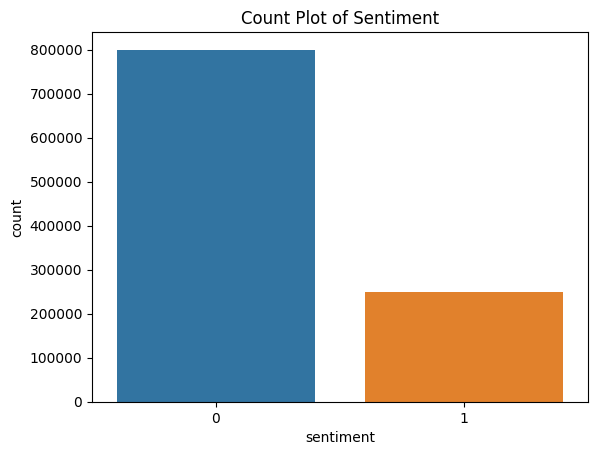

In [9]:
sns.countplot(x = df["sentiment"])
plt.title("Count Plot of Sentiment")
plt.show()

The classes are imbalanced with the samples in the negative class being far more than that of positive class

In [10]:
# Checking for null values
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [11]:
# Checking for empty rows
print("text", df.text[df.text.str.strip()==''].count())

text 0


In [12]:
# Check for duplicate rows
df.duplicated().sum()

11664

## Data preprocessing

### Remove duplicate rows

In [13]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [14]:
df.duplicated().sum()

0

### Converting text to lowercase

In [15]:
df["text"] = df["text"].str.lower()

In [16]:
df.head()

,sentiment,text
0,0,is upset that he can't update his facebook by ...
1,0,@kenichan i dived many times for the ball. man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@kwesidei not the whole crew


### Removing user handles

In [17]:
df["text"] = df.text.str.replace(r"@[\w-]* *", "", regex=True)

In [18]:
df.head()

,sentiment,text
0,0,is upset that he can't update his facebook by ...
1,0,i dived many times for the ball. managed to sa...
2,0,my whole body feels itchy and like its on fire
3,0,"no, it's not behaving at all. i'm mad. why am ..."
4,0,not the whole crew


### Removing punctuations

In [19]:
def remove_punctuations(column):
    punctuation_signs = list("?:!.,;:'()@-—")
    column = column.str.replace("\r", " ")
    column = column.str.replace("\n", " ")
    column = column.str.replace("    ", " ")
    column = column.str.replace('"', ' ')
    column = column.str.lower()
    for punct_sign in punctuation_signs:
        column = column.str.replace(punct_sign, ' ')
    column = column.str.replace("'s", " ")
    column = column.str.replace("|"," ")
    column = column.str.replace("'"," ")
    column = column.str.replace(","," ")
    return column

In [20]:
df["text"] = remove_punctuations(df["text"])

In [21]:
df.head()

,sentiment,text
0,0,is upset that he can t update his facebook by ...
1,0,i dived many times for the ball managed to sa...
2,0,my whole body feels itchy and like its on fire
3,0,no it s not behaving at all i m mad why am ...
4,0,not the whole crew


### Lemmatizing the text

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
df["text"] = df["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

In [24]:
df.iloc[1].text

'i dived many time for the ball managed to save 50% the rest go out of bound'

### Removing stop words

In [25]:
stop = stopwords.words('english')

In [26]:
for word in stop:
    df["text"] = df["text"].str.replace(" "+word+" ", ' ')

In [27]:
df.head()

,sentiment,text
0,0,is upset update facebook texting might cry a r...
1,0,i dived many time ball managed save 50% rest g...
2,0,my whole body feel itchy like fire
3,0,no behaving mad see there
4,0,not whole crew


### Word cloud for positive tweets

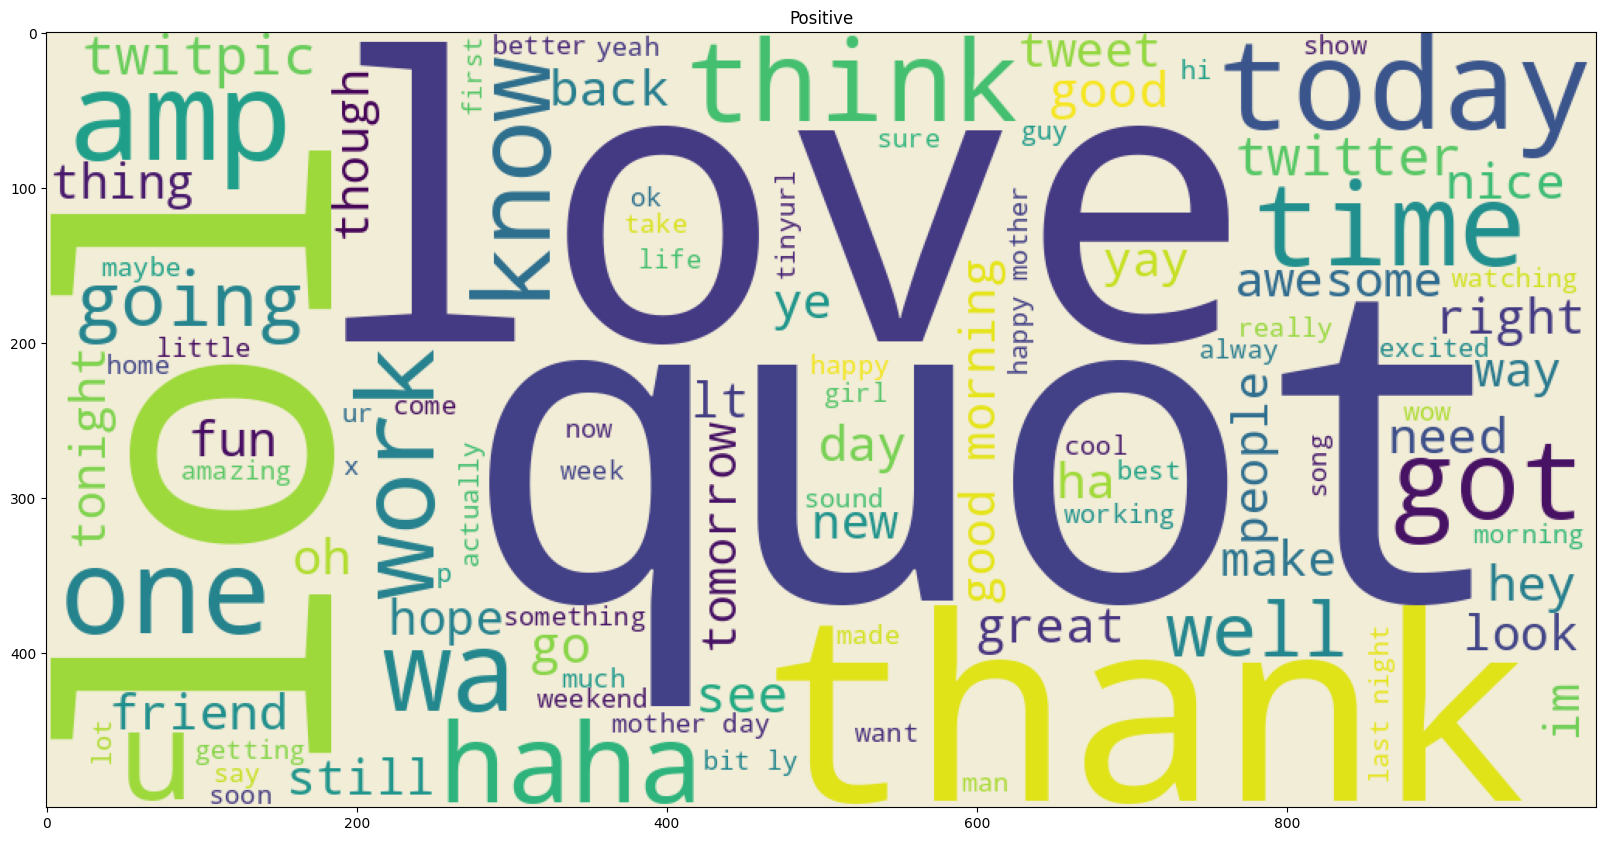

In [36]:
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(" ".join(sentence for sentence in df[df["sentiment"]==1].text))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

### Word cloud for negative tweets

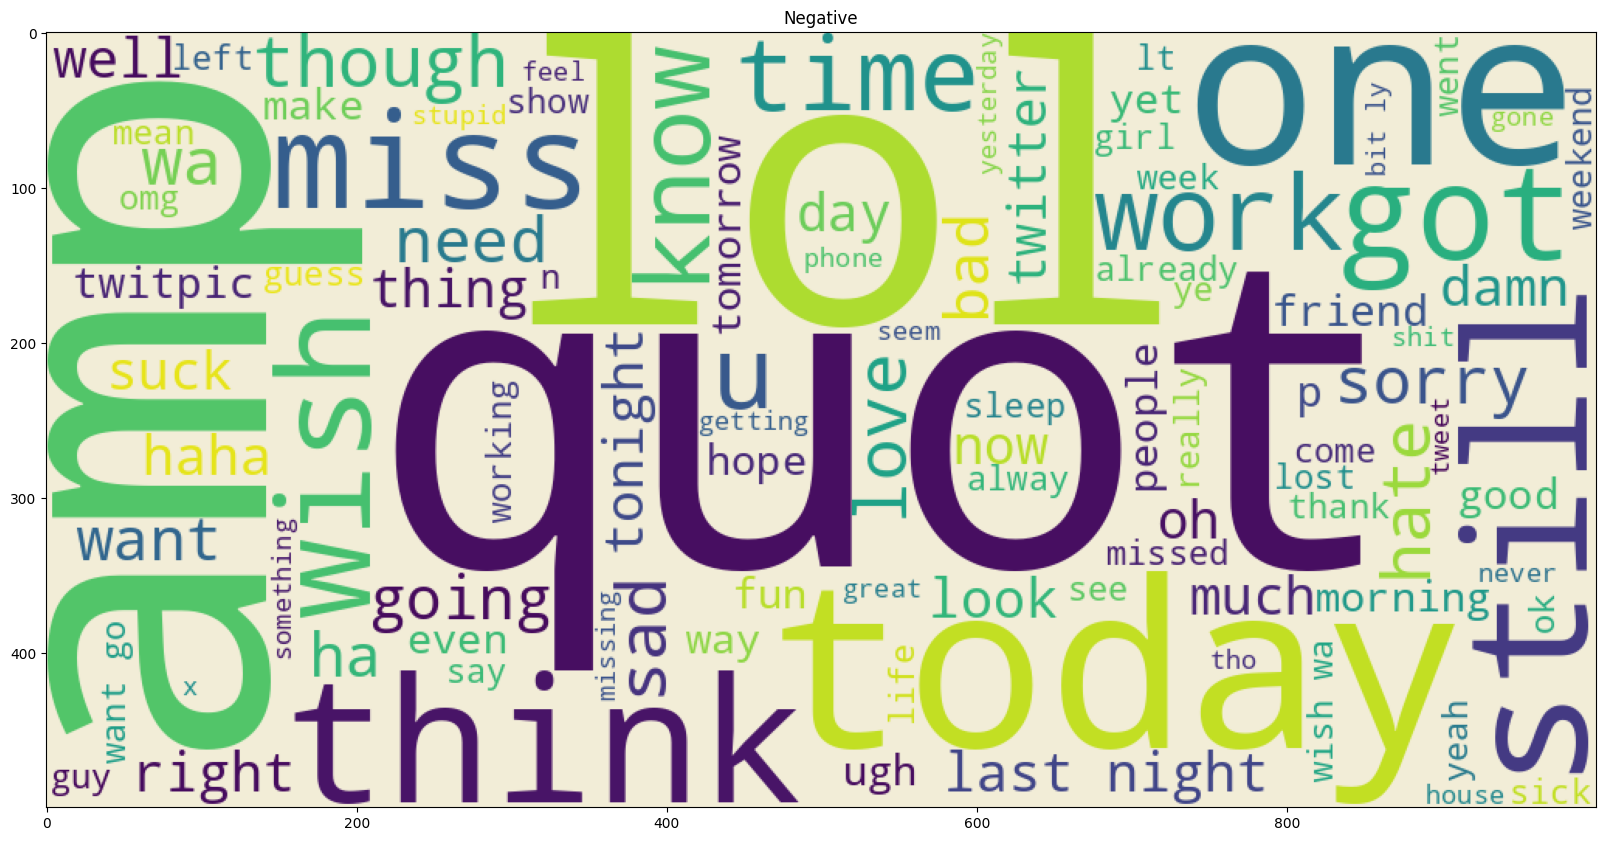

In [37]:
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(" ".join(sentence for sentence in df[df["sentiment"]==0].text))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Negative")
plt.show()

## Training the model

### Splitting into train and test data

In [38]:
X = df["text"]
y = df["sentiment"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [40]:
del df, X, y

### Feature extraction using TfidfVectorizer

In [41]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=3000)

In [42]:
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(min_df=3000, stop_words='english')

In [43]:
X_train = pd.DataFrame(tfidf_vectorizer.transform(X_train).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [44]:
X_train.head()

,10,30,able,actually,ago,amazing,amp,anymore,away,awesome,...,working,world,wow,wrong,ya,yay,yeah,year,yes,yesterday
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.49358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_test = pd.DataFrame(tfidf_vectorizer.transform(X_test).toarray())

In [46]:
X_test.columns = tfidf_vectorizer.get_feature_names_out()

In [47]:
X_test.head()

,10,30,able,actually,ago,amazing,amp,anymore,away,awesome,...,working,world,wow,wrong,ya,yay,yeah,year,yes,yesterday
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training model without class balancing

In [54]:
model = PassiveAggressiveClassifier()

In [55]:
model.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [56]:
y_pred = model.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred, target_names=["Negative","Positve"]))

              precision    recall  f1-score   support

    Negative       0.82      0.86      0.84    158037
     Positve       0.47      0.38      0.42     49345

    accuracy                           0.75    207382
   macro avg       0.64      0.62      0.63    207382
weighted avg       0.73      0.75      0.74    207382



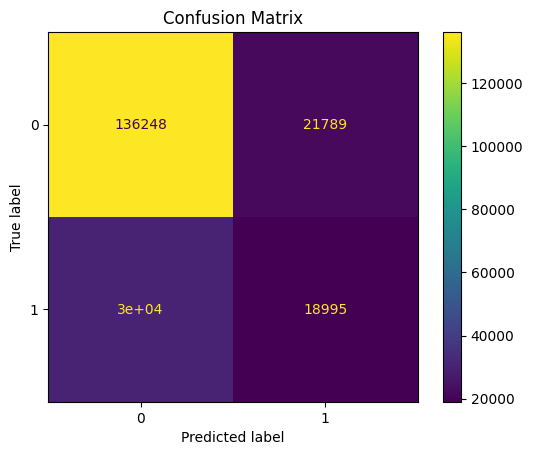

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title("Confusion Matrix")
plt.show()

In [59]:
X_test.shape

(207382, 281)

### Using random undersampling to balance the classes

In [38]:
from imblearn.under_sampling import RandomUnderSampler

In [39]:
rus = RandomUnderSampler(random_state=42, sampling_strategy="not minority")

In [40]:
X_res, y_res = rus.fit_resample(X_train, y_train)

In [41]:
del X_train, y_train

In [42]:
y_res.value_counts()

sentiment
0    197382
1    197382
Name: count, dtype: int64

In [43]:
X_res.head()

,10,30,able,actually,ago,amazing,amp,anymore,away,awesome,...,working,world,wow,wrong,ya,yay,yeah,year,yes,yesterday
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
model = LogisticRegression()

In [69]:
model.fit(X_res, y_res)

LogisticRegression()

In [70]:
y_pred = model.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred, target_names=["Negative","Positve"]))

              precision    recall  f1-score   support

    Negative       0.89      0.64      0.75    158037
     Positve       0.40      0.76      0.52     49345

    accuracy                           0.67    207382
   macro avg       0.65      0.70      0.63    207382
weighted avg       0.78      0.67      0.69    207382



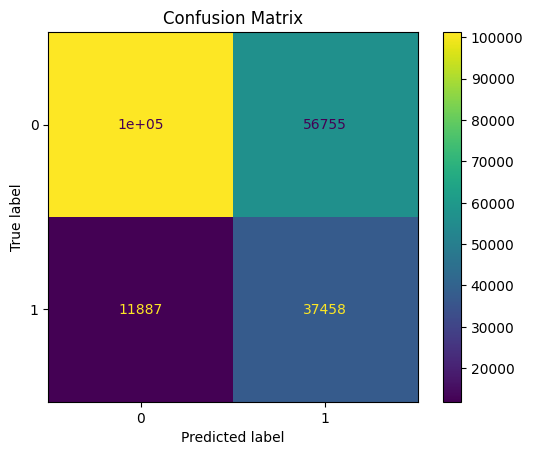

In [72]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title("Confusion Matrix")
plt.show()